In [43]:
 # !pip install pandas scikit-learn nltk

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import time
import matplotlib.pyplot as plt 
import string
from collections import Counter

nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [45]:
file_path = r'D:\Codes\NewsClassifier\News_Category_Dataset_v3.json'
df2 = pd.read_json(file_path, lines=True)
df2['text'] = df2['headline'] + " " + df2['short_description']
df2 = df2[['category', 'text']]

{'U.S. NEWS': 1377, 'COMEDY': 5400, 'PARENTING': 8791, 'WORLD NEWS': 3299, 'CULTURE & ARTS': 1074, 'TECH': 2104, 'SPORTS': 5077, 'ENTERTAINMENT': 17362, 'POLITICS': 35602, 'WEIRD NEWS': 2777, 'ENVIRONMENT': 1444, 'EDUCATION': 1014, 'CRIME': 3562, 'SCIENCE': 2206, 'WELLNESS': 17945, 'BUSINESS': 5992, 'STYLE & BEAUTY': 9814, 'FOOD & DRINK': 6340, 'MEDIA': 2944, 'QUEER VOICES': 6347, 'HOME & LIVING': 4320, 'WOMEN': 3572, 'BLACK VOICES': 4583, 'TRAVEL': 9900, 'MONEY': 1756, 'RELIGION': 2577, 'LATINO VOICES': 1130, 'IMPACT': 3484, 'WEDDINGS': 3653, 'COLLEGE': 1144, 'PARENTS': 3955, 'ARTS & CULTURE': 1339, 'STYLE': 2254, 'GREEN': 2622, 'TASTE': 2096, 'HEALTHY LIVING': 6694, 'THE WORLDPOST': 3664, 'GOOD NEWS': 1398, 'WORLDPOST': 2579, 'FIFTY': 1401, 'ARTS': 1509, 'DIVORCE': 3426}


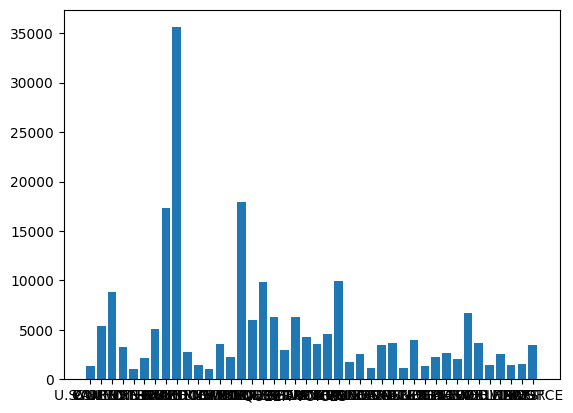

In [46]:
#issue 1 - visualising the distriubution of all classes in the dataset. 
category_count = {}
classes = []
for i in df2['category']:
    if i in category_count:
        category_count[i] += 1
    else:
        category_count[i] = 1
        classes.append(i)
print(category_count)

plt.bar(range(len(category_count)), list(category_count.values()), align='center')
plt.xticks(range(len(category_count)), list(category_count.keys()))
plt.show()

total no of classes:  42
28


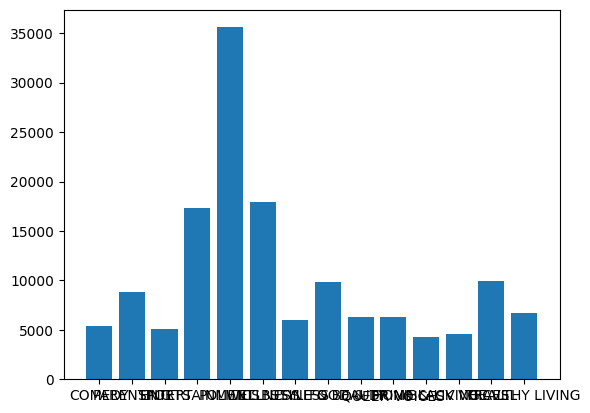

209527
144167


In [47]:
#removing minor classes
low_count_category = set()
for i , j in category_count.items():
    if j < 4000:
        low_count_category.add(i)
        classes.remove(i)

print("total no of classes: " , len(category_count))
print(len(low_count_category))

for i in low_count_category:
    del category_count[i]

plt.bar(range(len(category_count)), list(category_count.values()), align='center')
plt.xticks(range(len(category_count)), list(category_count.keys()))
plt.show()

print(len(df2.index))
indices = df2[df2['category'].isin(low_count_category)].index
df2.drop(indices, inplace=True)
print(len(df2.index))


In [ ]:
stop_words = set(stopwords.words('english'))
#ref- stopwords is an inbuilt fn which has repitiive words like this, or, that, and etc. 

def preprocess_text(text,category):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in stop_words and token not in string.punctuation]

    lemmatizer = nltk.WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(lemmas) 
    
df2['processed_text'] = df2.apply(lambda row: preprocess_text(row['text'], row['category']), axis=1)
#ref- apply means it will loop through everything in the dataframe and apply the specified fn to each and every one. 
#ref- axis =1 means it will apply row wise, default is column wise.

{'BLACK VOICES': {'black': 1558, 'new': 462, 'police': 405, 'woman': 376, 'life': 346, 'people': 345, 'say': 342, 'year': 309, 'said': 304, 'white': 303}, 'BUSINESS': {'business': 875, 'company': 707, 'new': 656, 'year': 537, 'job': 471, 'woman': 470, 'people': 467, 'time': 461, 'one': 457, 'make': 382}, 'COMEDY': {'trump': 1285, 'donald': 673, 'video': 641, 'show': 527, 'like': 405, 'colbert': 403, 'jimmy': 400, 'new': 363, 'get': 350, 'one': 345}, 'ENTERTAINMENT': {'new': 2041, 'show': 1262, 'star': 1155, 'movie': 1122, 'say': 1112, 'film': 1103, 'one': 1018, 'trump': 1017, 'year': 969, 'first': 900}, 'FOOD & DRINK': {'recipe': 1599, 'food': 1256, 'photo': 892, 'make': 868, 'best': 769, 'day': 652, 'one': 565, 'like': 519, 'way': 503, 'new': 459}, 'HEALTHY LIVING': {'life': 942, 'health': 778, 'way': 668, 'people': 622, 'one': 617, 'time': 580, 'new': 512, 'make': 502, 'thing': 495, 'get': 481}, 'HOME & LIVING': {'home': 1836, 'photo': 1687, 'idea': 586, 'day': 550, 'make': 524, 'hou

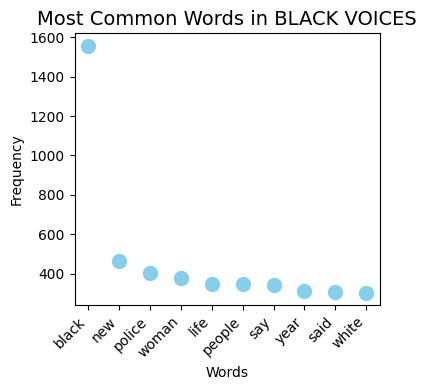

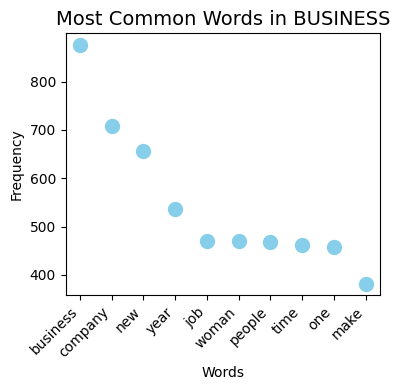

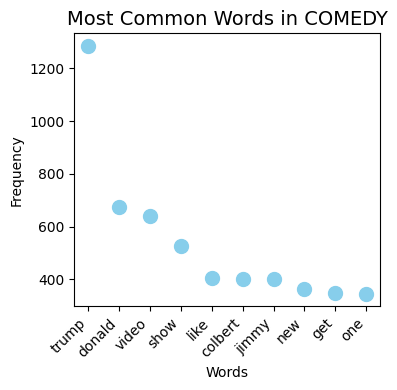

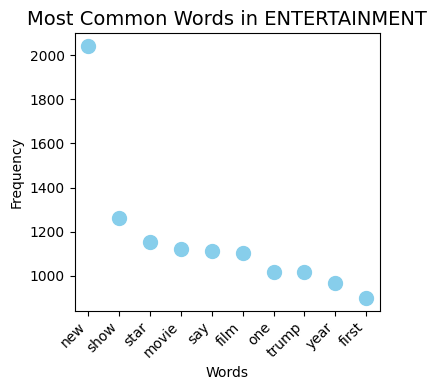

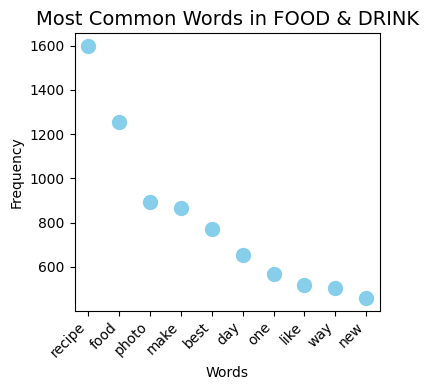

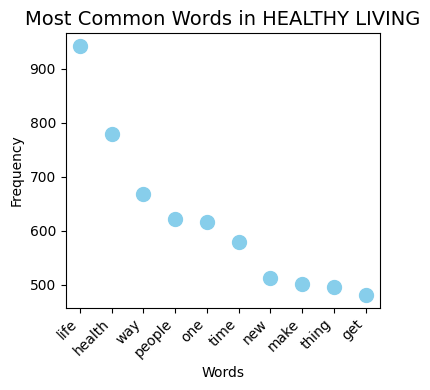

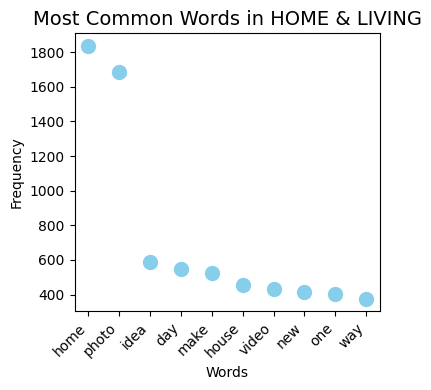

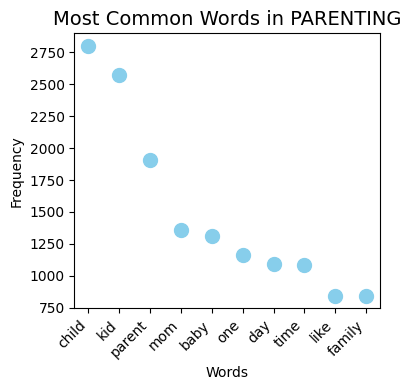

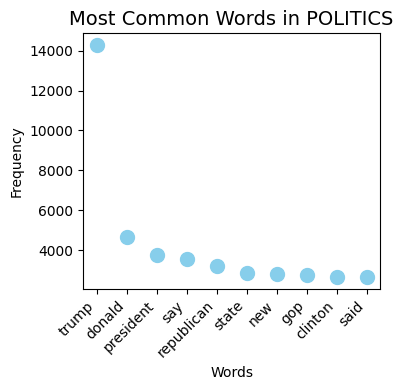

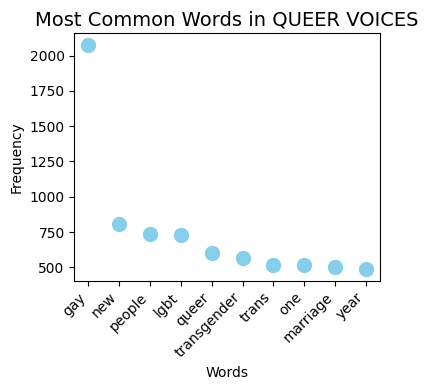

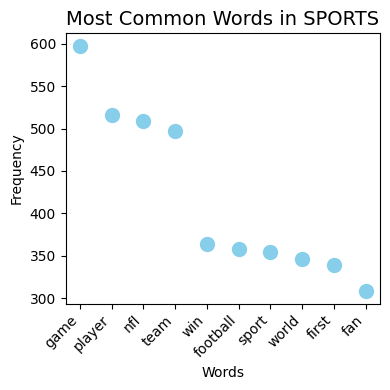

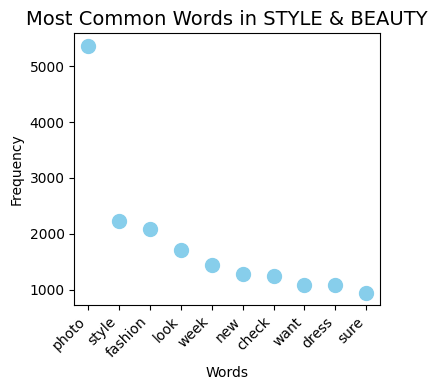

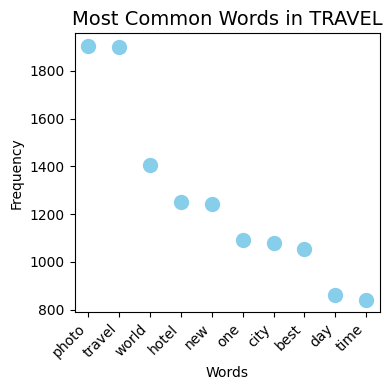

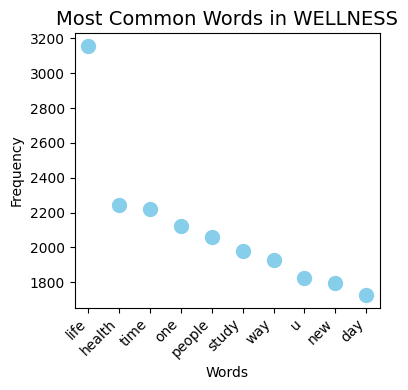

In [59]:
category_freq_dict = {}

for category, group in df2.groupby('category'):
    full_text = ' '.join(group['processed_text'].astype(str).tolist())
    tokens = nltk.word_tokenize(full_text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in string.punctuation and token not in stop_words]
    counter = Counter(tokens)
    common_words = {}
    for word,freq in counter.most_common(10):
        common_words[word] = freq
    category_freq_dict[category] = common_words

print(category_freq_dict)

for i in category_freq_dict :
    inner_dict = category_freq_dict[i]
    words = list(inner_dict.keys())
    frequencies = list(inner_dict.values())

    plt.figure(figsize=(4 , 4))
    plt.scatter(words, frequencies, color='skyblue', s=100)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Most Common Words in {i}', fontsize=14)
    plt.tight_layout()
    plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df2['processed_text'], df2['category'], test_size=0.2)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', MultinomialNB())
]) 

param_grid = {
    'classifier__alpha' : [0.1, 0.01, 1, 10], 
    "classifier__fit_prior" : [False,True] #that double underscore is important
}
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

grid_search = GridSearchCV(pipeline,
                           param_grid = param_grid,
                           cv = 5,
                           scoring = scoring,
                           refit='accuracy')
grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)
comparison = results_df[[
    'params',
    'mean_test_accuracy',
    'mean_test_precision',
    'mean_test_recall',
    'mean_test_f1'
]].sort_values(by='mean_test_accuracy', ascending=False) 

print(comparison)

best_model = grid_search.best_estimator_


d:\Codes\NewsClassifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Codes\NewsClassifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Codes\NewsClassifier\venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Codes\NewsClassifier\venv

                                              params  mean_test_accuracy  \
1  {'classifier__alpha': 0.1, 'classifier__fit_pr...            0.690340   
6  {'classifier__alpha': 10, 'classifier__fit_pri...            0.688554   
3  {'classifier__alpha': 0.01, 'classifier__fit_p...            0.685649   
4  {'classifier__alpha': 1, 'classifier__fit_prio...            0.683300   
5  {'classifier__alpha': 1, 'classifier__fit_prio...            0.681531   
0  {'classifier__alpha': 0.1, 'classifier__fit_pr...            0.665170   
2  {'classifier__alpha': 0.01, 'classifier__fit_p...            0.659430   
7  {'classifier__alpha': 10, 'classifier__fit_pri...            0.563013   

   mean_test_precision  mean_test_recall  mean_test_f1  
1             0.695737          0.690340      0.664267  
6             0.691326          0.688554      0.664224  
3             0.689206          0.685649      0.659545  
4             0.699646          0.683300      0.687151  
5             0.705066        

'best_model = grid_search.best_estimator_\naccuracy = best_model.score(X_test, y_test)\nprint(f"Test set accuracy: {accuracy:.3f}") '

In [79]:
print("Training the model...")
start_time = time.time()
grid_search.best_estimator_.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

print("Making predictions...")
y_pred = grid_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))

Training the model...
Training completed in 1.96 seconds (0.03 minutes)
Making predictions...
Accuracy: 0.6933

Classification Report:
                precision    recall  f1-score   support

  BLACK VOICES       0.63      0.21      0.32       869
      BUSINESS       0.70      0.37      0.48      1235
        COMEDY       0.71      0.31      0.43      1088
 ENTERTAINMENT       0.63      0.77      0.69      3431
  FOOD & DRINK       0.77      0.73      0.75      1356
HEALTHY LIVING       0.60      0.06      0.11      1353
 HOME & LIVING       0.83      0.59      0.69       866
     PARENTING       0.69      0.59      0.64      1757
      POLITICS       0.73      0.93      0.82      7133
  QUEER VOICES       0.81      0.48      0.60      1248
        SPORTS       0.77      0.54      0.63       975
STYLE & BEAUTY       0.80      0.75      0.77      1977
        TRAVEL       0.74      0.77      0.76      2008
      WELLNESS       0.56      0.84      0.67      3538

      accuracy         

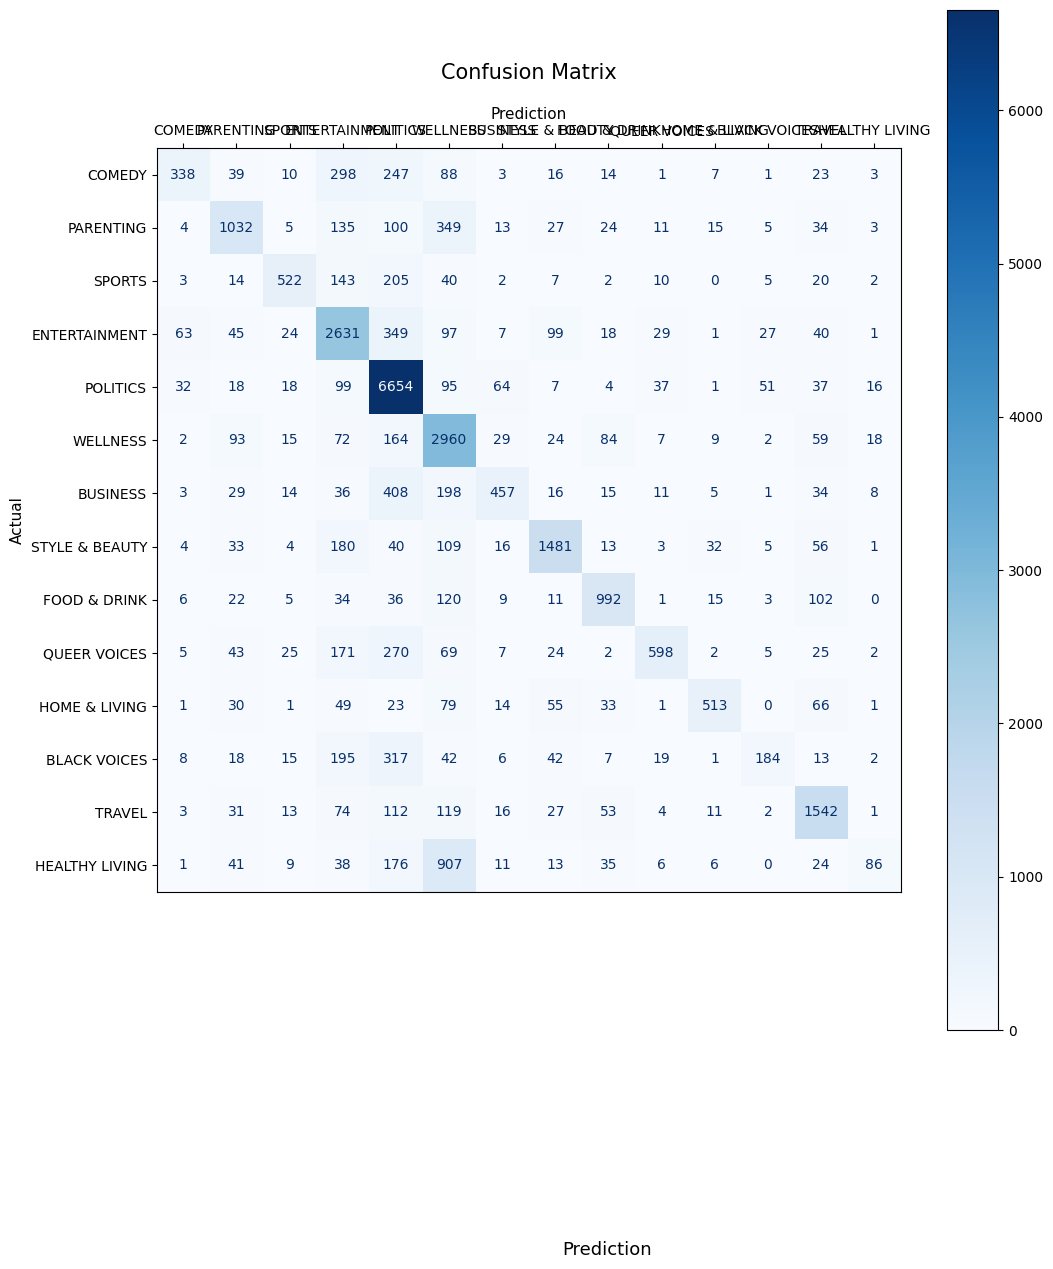

In [80]:
#confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(y_test, y_pred, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

fig, ax = plt.subplots(figsize=(12, 15))
disp.plot(cmap=plt.cm.Blues, ax=ax)

plt.title('Confusion Matrix', fontsize=15, pad=20)
plt.xlabel('Prediction', fontsize=11)
plt.ylabel('Actual', fontsize=11)
plt.gca().xaxis.set_label_position('top')
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)

plt.show()
